In [ ]:
!pip install lmfit scikit-image

Saving WhatsApp Image 2024-11-09 at 18.25.13.jpeg to WhatsApp Image 2024-11-09 at 18.25.13.jpeg
User uploaded file "WhatsApp Image 2024-11-09 at 18.25.13.jpeg" with length 9363 bytes.
Image 'WhatsApp Image 2024-11-09 at 18.25.13.jpeg' loaded and downsampled successfully.
Preprocessing applied: Normalization, Gaussian Noise Removal, Morphological Opening, Median Filtering.
Original Grid Size: 5.0
Original Points: 500
Image Points: 240
New Grid Size: 2.4000 units

Starting composite model fitting...
[[Model]]
    (((Model(TEM00, prefix='TEM00_') + Model(TEM10, prefix='TEM10_')) + Model(TEM01, prefix='TEM01_')) + Model(TEM11, prefix='TEM11_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 76800
    # variables        = 28
    chi-square         = 51.1278963
    reduced chi-square = 6.6597e-04
    Akaike info crit   = -561707.558
    Bayesian info crit = -561448.587
    R-squared          = 0.91515233
##  Warning: uncertainties c

,AIC,BIC,R_squared
Composite,-561707.557514,-561448.586637,0.915152



=== Mode Contributions ===


,Percentage
Mode,
TEM00,18.712803
TEM10,36.564611
TEM01,39.062802
TEM11,5.659785



Plotting composite fit results...


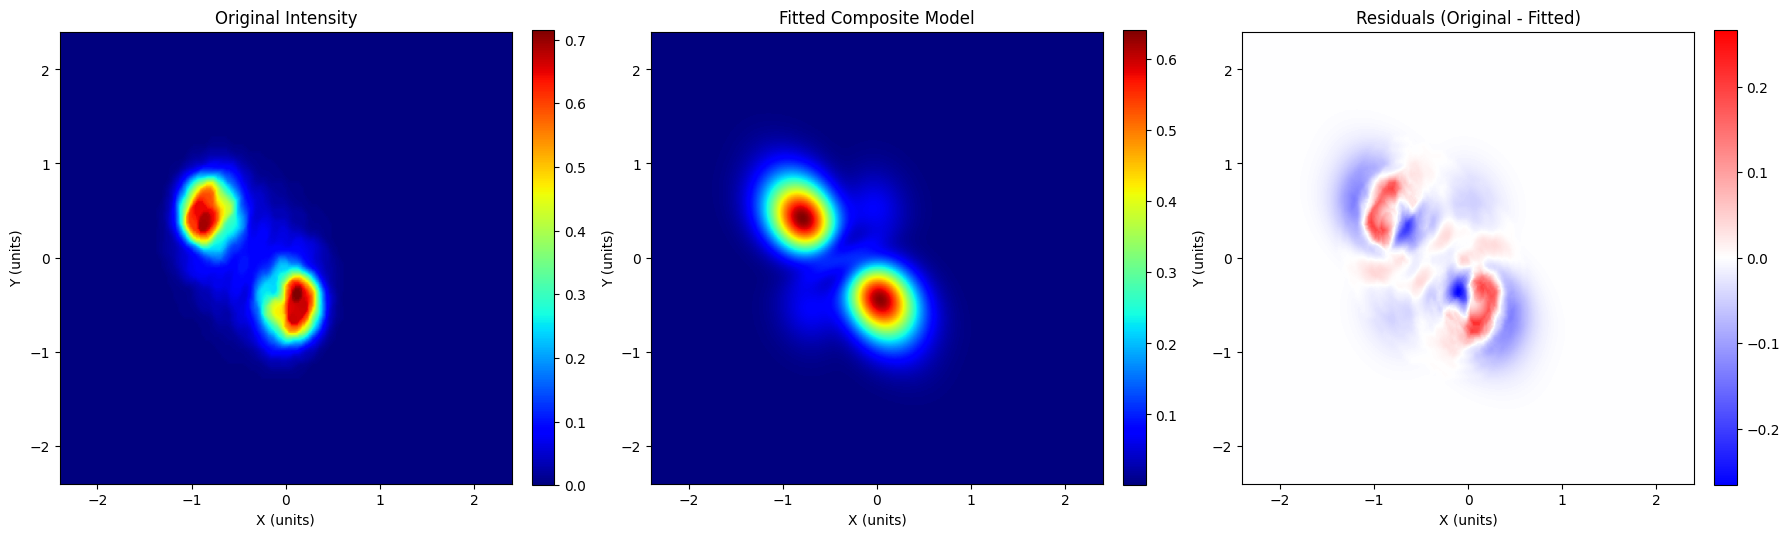


Plotting individual mode contributions...


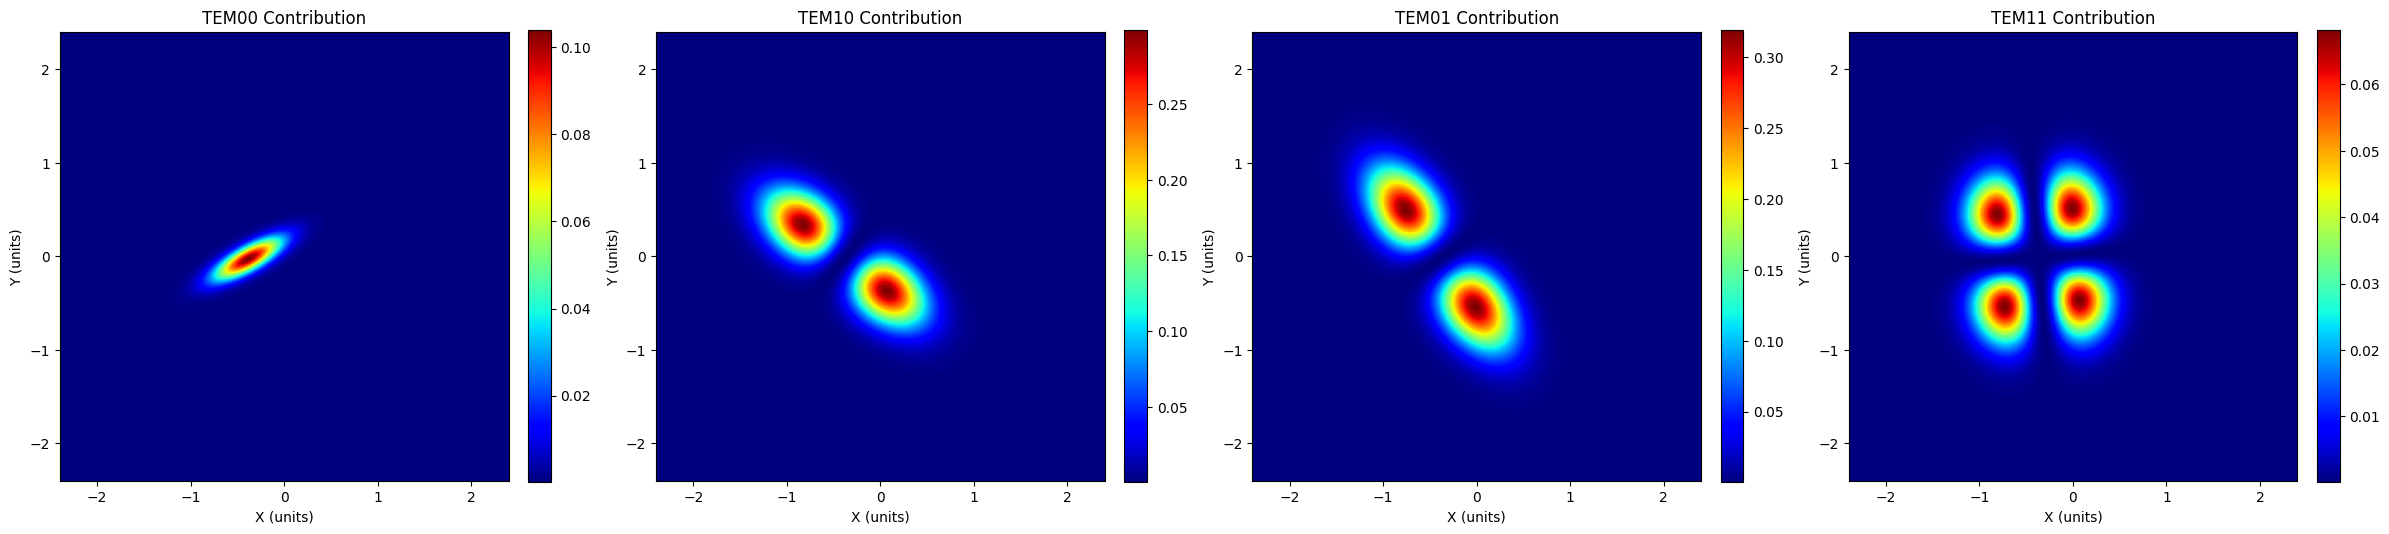

In [ ]:
"""Optimized TEM Superposition Regression with Corrected Hermite Polynomial Computation.ipynb

Optimized for performance using downsampling, vectorization, and JIT compilation with Numba.
Corrected Hermite polynomial computation to avoid size mismatches.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
from lmfit import Model, Parameters
from skimage import io, exposure
from skimage.transform import resize
from skimage.filters import gaussian, median
from skimage.morphology import opening, disk
from google.colab import files
import pandas as pd
import os
from numba import njit, prange

# Upload the image
uploaded = files.upload()

for filename in uploaded.keys():  # Change if more than 1 picture is uploaded
    image_path = filename
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes.')

# Hermite polynomial
@njit
def hermite_poly(n, x):
    """
    Compute the physicist's Hermite polynomial H_n(x) using a recursive relation.

    Parameters:
    - n: Order of the Hermite polynomial.
    - x: Input value or array.

    Returns:
    - H_n(x): The Hermite polynomial evaluated at x.
    """
    if n == 0:
        return 1.0
    elif n == 1:
        return 2.0 * x
    else:
        H_nm1 = 1.0  # H_0(x)
        H_n = 2.0 * x  # H_1(x)
        for i in range(1, n):
            H_np1 = 2.0 * x * H_n - 2.0 * i * H_nm1
            H_nm1 = H_n
            H_n = H_np1
        return H_n

@njit(parallel=True)
def compute_intensity(x_arr, y_arr, amplitude, x0, y0, sigma_x, sigma_y, theta, m, n):
    """
    Compute the intensity for each (x, y) point based on TEM mode parameters.

    Parameters:
    - x_arr: Array of x-coordinates.
    - y_arr: Array of y-coordinates.
    - amplitude: Amplitude parameter.
    - x0, y0: Center coordinates.
    - sigma_x, sigma_y: Standard deviations in x and y.
    - theta: Rotation angle.
    - m, n: TEM mode indices.

    Returns:
    - Z: Array of computed intensities.
    """
    N = x_arr.shape[0]
    Z = np.empty(N, dtype=np.float64)
    for i in prange(N):
        x = x_arr[i]
        y = y_arr[i]

        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        xr = cos_theta * (x - x0) + sin_theta * (y - y0)
        yr = -sin_theta * (x - x0) + cos_theta * (y - y0)

        xi = np.sqrt(2) * xr / sigma_x
        eta = np.sqrt(2) * yr / sigma_y

        Hm = hermite_poly(m, xi)
        Hn = hermite_poly(n, eta)

        E_mn = Hm * Hn * np.exp(-(xr**2)/(sigma_x**2) - (yr**2)/(sigma_y**2))

        Z[i] = amplitude * (E_mn)**2
    return Z

def TEM_mn_intensity_fit(m, n):
    """
    Generates a TEM_mn intensity function based on Hermite polynomials and Gaussian envelopes.

    Parameters:
    - m: Mode index in the x-direction.
    - n: Mode index in the y-direction.

    Returns:
    - A function that calculates the intensity for given parameters.
    """
    @njit
    def intensity(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
        x_arr = xy[0]
        y_arr = xy[1]
        Z = compute_intensity(x_arr, y_arr, amplitude, x0, y0, sigma_x, sigma_y, theta, m, n)
        return Z + offset
    return intensity

# Defining individual TEM modes (e.g., TEM00, TEM10, TEM01, etc.)
def TEM00(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(0, 0)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM10(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(1, 0)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM01(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(0, 1)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM11(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(1, 1)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM12(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(1, 2)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM21(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(2, 1)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM22(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(2, 2)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM02(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(0, 2)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM20(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(2, 0)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM30(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(3, 0)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM03(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(0, 3)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM40(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(4, 0)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

def TEM04(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    return TEM_mn_intensity_fit(0, 4)(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

from skimage import io as sio
from skimage import transform
from PIL import Image
import matplotlib.colors as mcolors

from skimage import transform, img_as_float
from scipy.spatial import cKDTree

def load_image(image_path, downsample_factor=2, invert=False): #this function only works for loading grayscale or jet images
    """
    Loads an image with a Jet colormap, converts it to grayscale by mapping each pixel
    to the closest color in the Jet colormap using an efficient nearest neighbor search,
    normalizes the intensity, and downsamples it.

    Parameters:
    - image_path: Path to the image file.
    - downsample_factor: Factor by which to downsample the image.
    - invert: Boolean flag to invert the grayscale mapping.

    Returns:
    - Z: 2D normalized grayscale intensity array.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Load the image as a floating-point array
    img = img_as_float(sio.imread(image_path))

    # Handling different image modes
    if img.ndim == 2:
        # Grayscale image: Expand to RGB by duplicating channels
        img = np.stack([img, img, img], axis=-1)
    elif img.ndim == 3:
        if img.shape[2] == 4:
            # RGBA image: Convert to RGB by discarding the alpha channel
            img = img[..., :3]
        elif img.shape[2] != 3:
            raise ValueError(f"Unsupported number of channels: {img.shape[2]}")
    else:
        raise ValueError(f"Unsupported image shape: {img.shape}")

    img = np.clip(img, 0, 1)

    # Create the Jet colormap lookup table (LUT)
    jet = plt.get_cmap('jet', 256)  # 256 discrete colors
    lut = jet(np.linspace(0, 1, 256))[:, :3]  # Extract RGB, ignore alpha

    # Reshape LUT for KDTree
    lut_reshaped = lut.reshape(256, 3)

    # Build KDTree for efficient nearest neighbor search
    tree = cKDTree(lut_reshaped)

    # Reshape image to a 2D array of pixels
    pixels = img.reshape(-1, 3)

    # Query the nearest color in LUT for each pixel
    _, idx = tree.query(pixels, k=1)

    # Reshape the indices back to the image shape
    out = idx.reshape(img.shape[0], img.shape[1])

    Z = out / 255.0

    # Invert the grayscale mapping if prompted
    if invert:
        Z = 1.0 - Z

    # Downsample the image if faster results are needed.
    if downsample_factor > 1:
        new_height = max(1, Z.shape[0] // downsample_factor)
        new_width = max(1, Z.shape[1] // downsample_factor)
        Z = transform.resize(
            Z,
            (new_height, new_width),
            anti_aliasing=True
        )

    return Z

def generate_spatial_grid(Z, grid_size):
    """
    Generates spatial grids based on image dimensions and grid size.

    Parameters:
    - Z: 2D intensity array.
    - grid_size: Physical extent of the grid (from -grid_size to +grid_size).

    Returns:
    - X, Y: Meshgrid arrays.
    """
    ny, nx = Z.shape
    x = np.linspace(-grid_size, grid_size, nx)
    y = np.linspace(-grid_size, grid_size, ny)
    X, Y = np.meshgrid(x, y)
    return X, Y

# Initialize parameters based on image
def initialize_parameters(Z, new_grid_size):
    """
    Initializes fitting parameters based on the image's intensity distribution.

    Parameters:
    - Z: 2D intensity array.
    - new_grid_size: Physical extent of the grid.

    Returns:
    - initial_params: Dictionary of initial parameter guesses.
    """
    total_intensity = np.sum(Z)
    ny, nx = Z.shape
    x = np.linspace(-new_grid_size, new_grid_size, nx)
    y = np.linspace(-new_grid_size, new_grid_size, ny)
    X, Y = np.meshgrid(x, y)
    x0 = np.sum(X * Z) / total_intensity
    y0 = np.sum(Y * Z) / total_intensity
    sigma_x = np.sqrt(np.sum(((X - x0)**2) * Z) / total_intensity)
    sigma_y = np.sqrt(np.sum(((Y - y0)**2) * Z) / total_intensity)
    amplitude = np.max(Z) - np.min(Z)
    offset = np.min(Z)
    theta = 0.0  # Assume no initial rotation, change if you have any idea

    initial_params = {
        'amplitude': amplitude,
        'x0': x0,
        'y0': y0,
        'sigma_x': sigma_x,
        'sigma_y': sigma_y,
        'theta': theta,
        'offset': offset
    }

    return initial_params

# Preprocessing
def preprocess_image(Z, sigma=1.0, disk_size=3, median_size=3):
    """
    Preprocesses the input image by normalizing, denoising with Gaussian filter,
    removing small bright spots using morphological opening, and applying a median filter.

    Parameters:
    - Z: 2D numpy array representing the input image.
    - sigma: Standard deviation for Gaussian kernel. Higher values result in more blurring.
    - disk_size: Radius of the disk-shaped structuring element for morphological opening.
    - median_size: Radius of the disk-shaped structuring element for median filtering.

    Returns:
    - Z_clean: The preprocessed and denoised image.
    """
    epsilon = 1e-9
    Z_normalized = (Z - np.min(Z)) / (np.max(Z) - np.min(Z) + epsilon)

    # Denoise
    Z_denoised = gaussian(Z_normalized, sigma=sigma, preserve_range=True)

    # Removing small bright spots using morphological opening
    footprint_open = disk(disk_size)
    Z_opened = opening(Z_denoised, footprint=footprint_open)

    # Median filtering
    footprint_median = disk(median_size)
    Z_clean = median(Z_opened, footprint=footprint_median)

    return Z_clean

def compute_fit_metrics(Z, Z_fit):
    """
    Computes fit metrics: AIC, BIC, and R².

    Parameters:
    - Z: Original 2D intensity array.
    - Z_fit: Fitted 2D intensity array.

    Returns:
    - metrics: Dictionary containing AIC, BIC, and R_squared.
    """
    residuals = Z - Z_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Z - np.mean(Z))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return ss_res, ss_tot, r_squared

def plot_fit_results(Z, Z_fit, X, Y, mode_str='Composite'):
    """
    Plots the original, fitted, and residual intensity distributions.

    Parameters:
    - Z: Original 2D intensity array.
    - Z_fit: Fitted 2D intensity array.
    - X, Y: Meshgrid arrays.
    - mode_str: String representing the TEM mode.
    """
    residuals = Z - Z_fit

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Intensity
    im0 = axes[0].imshow(Z, extent=[X.min(), X.max(), Y.min(), Y.max()],
                         origin='lower', cmap='jet')
    axes[0].set_title('Original Intensity')
    axes[0].set_xlabel('X (units)')
    axes[0].set_ylabel('Y (units)')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Fitted Intensity
    im1 = axes[1].imshow(Z_fit, extent=[X.min(), X.max(), Y.min(), Y.max()],
                         origin='lower', cmap='jet')
    axes[1].set_title(f'Fitted {mode_str} Model')
    axes[1].set_xlabel('X (units)')
    axes[1].set_ylabel('Y (units)')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Residuals
    im2 = axes[2].imshow(residuals, extent=[X.min(), X.max(), Y.min(), Y.max()],
                         origin='lower', cmap='bwr',
                         vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)))
    axes[2].set_title('Residuals (Original - Fitted)')
    axes[2].set_xlabel('X (units)')
    axes[2].set_ylabel('Y (units)')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

def parse_mode(mode_str):
    """
    Parses the TEM mode string to extract the m and n indices.

    Parameters:
    - mode_str (str): String representing the TEM mode (e.g., 'TEM00', 'TEM01', etc.)

    Returns:
    - tuple: A tuple containing two integers (m, n) representing the mode indices.

    Raises:
    - ValueError: If the mode string does not start with 'TEM' followed by two digits.
    """
    if not mode_str.startswith('TEM') or len(mode_str) != 5:
        raise ValueError("Mode string must start with 'TEM' followed by two digits (e.g., 'TEM00').")
    try:
        m = int(mode_str[3])
        n = int(mode_str[4])
    except (IndexError, ValueError):
        raise ValueError("Mode string must have two digits after 'TEM' (e.g., 'TEM00').")
    return m, n

def compute_grid_parameters(Z, original_grid_size, original_points):
    """
    Computes the new grid size based on the dimensions of the cropped image.

    Parameters:
    - Z (np.ndarray): 2D intensity array representing the image.
    - original_grid_size (float): The original spatial extent of the grid (from -grid_size to +grid_size).
    - original_points (int): The original number of points along each axis used during beam generation.

    Returns:
    - new_grid_size (float): The adjusted spatial extent of the grid based on the image's dimensions.

    Example:
    >>> new_grid = compute_grid_parameters(Z, 5.0, 500)
    """
    # Assuming the image is square
    cropped_points = Z.shape[0]

    # Calculate the scale factor based on the ratio of cropped points to original points
    scale_factor = cropped_points / original_points

    # Adjust the grid size accordingly
    new_grid_size = original_grid_size * scale_factor

    return new_grid_size

# Limit the number of modes to reduce fitting time
TEM_modes = ['TEM00', 'TEM10', 'TEM01', 'TEM11']  # Increase for better results

def create_TEM_models(TEM_modes):
    """
    Creates lmfit Model instances for each specified TEM mode with unique prefixes.

    Parameters:
    - TEM_modes (list): List of TEM mode strings (e.g., ['TEM00', 'TEM10']).

    Returns:
    - TEM_models (dict): Dictionary mapping mode strings to their respective lmfit Model instances.
    """
    TEM_models = {}
    for mode in TEM_modes:
        # Get the corresponding TEM function
        TEM_func = globals()[mode]
        # Create a Model for each TEM mode with parameter prefixes to ensure uniqueness
        model = Model(TEM_func, independent_vars=['xy'], prefix=f'{mode}_')
        TEM_models[mode] = model
    return TEM_models

# Define the fitting workflow for composite model
def composite_fitting_workflow(image_path, TEM_modes, original_grid_size=5.0, original_points=500, sigma=1.0, downsample_factor=2):
    """
    Completes the fitting workflow: loads the image, applies preprocessing, fits a superposition of TEM modes,
    computes fit metrics, prints initial and fitted parameters, and determines the mode contributions.

    Parameters:
    - image_path: Path to the uploaded image.
    - TEM_modes: List of TEM mode strings to include in the superposition.
    - original_grid_size: Original grid size used during beam generation.
    - original_points: Original number of points along each axis.
    - sigma: Standard deviation for Gaussian noise removal.
    - downsample_factor: Factor by which to downsample the image for faster computation.
    """
    # Load and preprocess the image
    Z = load_image(image_path, downsample_factor=downsample_factor)
    print(f"Image '{image_path}' loaded and downsampled successfully.")

    Z_preprocessed = preprocess_image(Z, sigma=sigma)
    print("Preprocessing applied: Normalization, Gaussian Noise Removal, Morphological Opening, Median Filtering.")

    # Determine new grid size based on image dimensions
    new_grid_size = compute_grid_parameters(Z_preprocessed, original_grid_size, original_points)
    print(f"Original Grid Size: {original_grid_size}")
    print(f"Original Points: {original_points}")
    print(f"Image Points: {Z_preprocessed.shape[0]}")
    print(f"New Grid Size: {new_grid_size:.4f} units")

    # Create individual TEM models
    TEM_models_dict = create_TEM_models(TEM_modes)

    # Generate spatial grid
    X, Y = generate_spatial_grid(Z_preprocessed, new_grid_size)
    x = X.flatten()
    y = Y.flatten()
    xy = np.vstack((x, y))

    # Initialize lmfit Parameters
    params = Parameters()

    # Initialize parameters only once if multiple modes share the same center and sigma
    initial = initialize_parameters(Z_preprocessed, new_grid_size)

    for mode in TEM_modes:
        prefix = f'{mode}_'
        params.add(f'{prefix}amplitude', value=initial['amplitude']/len(TEM_modes), min=0.0, max=10.0)
        params.add(f'{prefix}x0', value=initial['x0'], min=-new_grid_size, max=new_grid_size)
        params.add(f'{prefix}y0', value=initial['y0'], min=-new_grid_size, max=new_grid_size)
        params.add(f'{prefix}sigma_x', value=initial['sigma_x'], min=0.1, max=new_grid_size)
        params.add(f'{prefix}sigma_y', value=initial['sigma_y'], min=0.1, max=new_grid_size)
        params.add(f'{prefix}theta', value=initial['theta'], min=-np.pi/4, max=np.pi/4)
        params.add(f'{prefix}offset', value=initial['offset']/len(TEM_modes), min=0.0, max=1.0)

    # Create composite model by summing individual TEM models
    composite_model = None
    for mode, model in TEM_models_dict.items():
        if composite_model is None:
            composite_model = model
        else:
            composite_model += model

    print("\nStarting composite model fitting...")
    try:
        result = composite_model.fit(Z_preprocessed.flatten(), params, xy=xy, method='leastsq', max_nfev=1000)
    except Exception as e:
        print(f"An error occurred during fitting: {e}")
        return

    print(result.fit_report())

    # Evaluate the fitted model
    Z_fit = result.eval(xy=xy).reshape(Z_preprocessed.shape)

    # Compute fit metrics
    ss_res, ss_tot, r_squared = compute_fit_metrics(Z_preprocessed, Z_fit)
    aic = result.aic
    bic = result.bic

    # Calculate percentage contributions based on amplitudes
    contributions = {}
    for mode in TEM_modes:
        amplitude = result.params[f'{mode}_amplitude'].value
        contributions[mode] = amplitude

    total_contribution = sum(contributions.values())
    if total_contribution == 0:
        contributions_percent = {mode: 0 for mode in TEM_modes}
    else:
        contributions_percent = {mode: (amp / total_contribution) * 100 for mode, amp in contributions.items()}

    # Display fit metrics
    print("\n=== Fit Metrics for Composite Model ===")
    metrics = pd.DataFrame({
        'AIC': [aic],
        'BIC': [bic],
        'R_squared': [r_squared]
    }, index=['Composite'])
    display(metrics)

    # Display mode contributions
    print("\n=== Mode Contributions ===")
    contributions_df = pd.DataFrame({
        'Mode': list(contributions_percent.keys()),
        'Percentage': list(contributions_percent.values())
    })
    display(contributions_df.set_index('Mode'))

    print("\nPlotting composite fit results...")
    plot_fit_results(Z_preprocessed, Z_fit, X, Y, mode_str='Composite')

    print("\nPlotting individual mode contributions...")
    Z_individual = {}
    for mode in TEM_modes:
        prefix = f'{mode}_'
        amplitude = result.params[f'{prefix}amplitude'].value
        x0 = result.params[f'{prefix}x0'].value
        y0 = result.params[f'{prefix}y0'].value
        sigma_x = result.params[f'{prefix}sigma_x'].value
        sigma_y = result.params[f'{prefix}sigma_y'].value
        theta = result.params[f'{prefix}theta'].value
        offset = result.params[f'{prefix}offset'].value

        # Evaluate TEM mode
        Z_mode = TEM_mn_intensity_fit(*parse_mode(mode))(xy,
                                                          amplitude,
                                                          x0,
                                                          y0,
                                                          sigma_x,
                                                          sigma_y,
                                                          theta,
                                                          offset)
        Z_individual[mode] = Z_mode.reshape(Z_preprocessed.shape)

    # Plot each mode's contribution scaled by amplitude
    num_modes = len(TEM_modes)
    fig, axes = plt.subplots(1, num_modes, figsize=(6*num_modes, 6))
    if num_modes == 1:
        axes = [axes]
    for ax, mode in zip(axes, TEM_modes):
        im = ax.imshow(Z_individual[mode], extent=[X.min(), X.max(), Y.min(), Y.max()],
                       origin='lower', cmap='jet')
        ax.set_title(f'{mode} Contribution')
        ax.set_xlabel('X (units)')
        ax.set_ylabel('Y (units)')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Adjust `downsample_factor` to balance between speed and accuracy
composite_fitting_workflow(
    image_path=image_path,
    TEM_modes=TEM_modes,
    original_grid_size=5.0,
    original_points=500,
    sigma=1.0,
    downsample_factor=2  # Increase this factor for more speedup (e.g., 4), but with lower resolution
)
